<b><center>Predicting Temperatures Using a Recurrent Neural Network</center></b>
<center>CSC 578 Final Project | Section 910 Online</center>
<center>Steven Jordan</center>

<h4><strong><span style="text-decoration: underline;">OBJECTIVE</span></strong></h4>
<p>For this project, I built a recurrent neural network designed to predict the hourly temperature of a location, based on the climate conditions and temperatures of the twenty four hours preceding the prediction.</p>


<p><span style="text-decoration: underline;"><strong>CONTENTS</strong></span></p>

1. [DATA OVERVIEW](#DATA-OVERVIEW)
2. [LIBRARY AND DATA IMPORTS](#LIBRARY-AND-DATA-IMPORTS)
3. [EXPLORATORY DATA ANALYSIS](#EXPLORATORY-DATA-ANALYSIS)
4. [DATA PRE-PROCESSING](#DATA-PRE--PROCESSING)
5. [MODEL CONSTRUCTION](#MODEL-CONSTRUCTION)
6. [MODEL EVALUTATION](#MODEL-EVALUATION)

<p><span style="text-decoration: underline;"><strong>DATA OVERVIEW</strong></span></p>
<p>The dataset was provided by the class website and a more detailed description is available on the <a href="https://www.kaggle.com/c/csc-578-final-project-spring-2019/data">Kaggle competition page</a>. It consists of hourly records of fourteen different climate and atmospheric attributes (e.g. temperature, atmospheric pressure, humidity, air density, etc.) that were recorded at the Max Planck Institute of Biogeochemistry in Jena, Germany from 2009 to 2016.</p>

<p><strong><u>LIBRARY AND DATA IMPORTS</u></strong></p>
<p>Below are the libraries and modules used for this final version of the model. In other versions of the model (which had larger MAEs), there were additional modules imported - however they were removed to maximize the efficiency of this code. The data provided was already separated into a training set and test set.</p>

In [1]:
import pandas as pd                                     # For easy dataframe management and processing
import matplotlib.pyplot as plt                         # For plotting visualizations
from sklearn.model_selection import train_test_split    # For creating the validation dataset
from scipy import stats                                 # For normalizing the data
import keras                                            # For building the RNN
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [2]:
# Load the training and test data
df_train = pd.read_csv("climate_hour_train.txt")
x_test = pd.read_csv("climate_Xtest.txt", header = None)

# Save the variable we're predicting 
y_variable = df_train['T (degC)']

In [3]:
df_train.head(3)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2


<p>In the dataframe above - one can see that the training set is separated into a Date Time column, and fourteen different characteristics. The Date Time column will later be removed as it is not a predictive feature.</p>

In [4]:
x_test.head(3)

,0,1,2,3,4,5,6,7,8,9,...,326,327,328,329,330,331,332,333,334,335
0,1007.19,2.06,274.65,1.89,98.8,7.09,7.00,0.09,4.34,6.95,...,92.0,6.83,6.29,0.55,3.91,6.27,1268.31,3.10,4.61,157.8
1,1007.06,2.22,274.82,2.06,98.9,7.17,7.09,0.08,4.39,7.04,...,89.8,6.94,6.23,0.71,3.88,6.22,1266.15,2.74,4.37,157.9
2,1007.43,2.04,274.61,1.87,98.8,7.08,6.99,0.08,4.33,6.94,...,89.8,6.91,6.20,0.70,3.86,6.20,1265.64,1.05,2.68,135.9


<p>In the dataframe above - one can see that the test set is pre-formatted to have the Date Time removed - and consists of 336 features - which are the 14 climate measurements concatenated over 24 hours (14 * 24 = 336). The training set will later be modified to match this format.</p>

<p><strong><u>EXPLORATORY DATA ANALYSIS</u></strong></p>

In [5]:
df_train.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000,52566.000000
mean,988.723002,9.172795,283.254265,4.779049,76.444300,13.357483,9.458133,3.899249,5.977212,9.568031,1216.718989,2.142170,3.539017,173.689628
std,8.190684,8.533081,8.605048,6.922701,16.430164,7.572008,4.201679,4.723265,2.666892,4.253017,40.439912,1.530832,2.313246,87.251111
min,918.500000,-22.760000,250.850000,-24.800000,13.060000,0.970000,0.810000,0.000000,0.510000,0.810000,1066.190000,0.000000,0.000000,0.000000
25%,983.750000,3.110000,277.242500,0.130000,65.810000,7.640000,6.170000,0.810000,3.890000,6.240000,1188.082500,1.010000,1.800000,120.800000
50%,989.140000,9.310000,283.430000,5.200000,79.700000,11.740000,8.850000,2.090000,5.595000,8.965000,1213.440000,1.790000,3.000000,197.100000
75%,994.070000,15.280000,289.370000,10.030000,89.800000,17.390000,12.320000,5.130000,7.780000,12.450000,1243.050000,2.880000,4.750000,233.800000
max,1012.740000,35.480000,309.690000,22.940000,100.000000,57.800000,28.040000,41.710000,17.940000,28.530000,1392.560000,12.580000,20.330000,360.000000


<p>One can see in the data description above, that the attribute values vary enormously in scale - from as low as -22.76 to as high as 1012.74 - so scaling the attributes will be essential before the construction of the neural network. The images below were generated via Tableau.</p>

<p style="text-align: center;"><strong>CLIMATE ATTRIBUTES OVER TIME (HOURLY)</strong></p>

<p><img src="https://lh4.googleusercontent.com/61F0bWaptto2W7XQVKUS0X8-dm2TgFixNHvx6epHHL63g5idMIuGe2Hdppljx6SlKxOZPEgTGtKhROKcky2q=w1280-h881-rw" alt="" width="976" height="478" /></p>
<p><img src="https://lh5.googleusercontent.com/mWw2-u3uC_DIBgcoZUJX3kFBawIdAT6VEXbEHpfRbo1d4vkwIp154d60FkFaBJzpTja-YDNowi9QgcEg314u=w1280-h881-rw" alt="" width="976" height="491" /></p>

<p>When one plots the data over time on an hour-by-hour basis, one can see in the data above that the scales vary widely - and some appear to be cyclical each year. One attribute - wind direction - varies so incredibly much on an hour by hour basis, that it appears to almost be noise.</p>

<p style="text-align: center;"><strong>CLIMATE ATTRIBUTES OVER TIME (MONTHLY AGGREGATE)</strong></p>

<p><img src="https://lh6.googleusercontent.com/kgUYtbkJMO-v31D27dTWpqVDuMNCvRSWJBwzGdFucA1Ft13drtpAo_ZNGoaSVVKU4niSJjXhflz1BXpDRGnF=w1280-h881-rw" alt="" width="976" height="478" /></p>
<p><img src="https://lh3.googleusercontent.com/CHPuKSSxy54_yCXI6_x3nefNby7iiSie1VmND0zMrX50ZmMg6JGj8pUYM7Y19iZicVvhoHUz7INfLCMT1o22=w1280-h881-rw" alt="" width="976" height="478" /></p>

<p>When aggregating by month, the yearly patterns become a lot more clear - even in wind direction, indicating that it's not just noise, but that there is a seasonal aspect to it.</p>

<p style="text-align: left;"><span style="text-decoration: underline;"><strong>DATA PRE-PROCESSING</strong></span></p>
<p>The x_training dataset is pre-processed by removing the Time Date variable, and then each row is transformed to be a concatated set of itself and the attributes of 24 hours preceding. Any rows with null values are removed. This decreases the size of the training set to be 52,542 rows. Then the "current" hour attributes are removed. &nbsp;</p>
<p>The y_training set has the first 24 rows removed - which correspond to the 24 rows removed from the x_training set. So now, each y-value temperature shares the index of the x-row with the attributes of the 24 hours preceding it.</p>

In [6]:
# Add in the additional columns of the past 24 hours
full_train = [df_train.iloc[:,1:].shift((24-1*i)) for i in range(24)]
full_train = pd.concat([df_train.iloc[:,1:], *full_train], axis=1)

# Drop rows with NaN values
full_train = full_train.dropna()

# Drop the "current hour" values, since we only want the 24 hours preceding.
x_train = full_train.iloc[:,14:]
print('x_train shape: ', x_train.shape)

# First 24 rows of the y variables are removed to match the x_training set
y_train = y_variable.iloc[24:]
print('y_train shape: ', y_train.shape)

x_train shape:  (52542, 336)
y_train shape:  (52542,)


<p>Now, because the values of the attribute vary dramatically in scale, the training and test sets are now normalized to their z-values.</p>

In [7]:
# Normalize the training and test sets
x_test = x_test.values
x_test = stats.zscore(x_test)

x_train = x_train.values
x_train = stats.zscore(x_train)

y_train = y_train.values
y_train = stats.zscore(y_train)

<p>Because I want to track and visualize the my model with a validation set, the below code splits 20% of the training set into validation. The sets are then reshaped to be 3D for use in the RNN.</p>

In [8]:
# Split training into training and validation
x_training, x_validation, y_training, y_validation = train_test_split(x_train, y_train, test_size=0.2)

In [9]:
# Reshape the sets to be 3D
x_training = x_training.reshape((x_training.shape[0], 24, 14))
x_validation = x_validation.reshape((x_validation.shape[0], 24, 14))
x_testing = x_test.reshape((x_test.shape[0], 24, 14))

<p style="text-align: left;"><span style="text-decoration: underline;"><strong>MODEL CONSTRUCTION</strong></span></p>
<p>Below you see the construction of an extremely simple LSTM neural network, with 10 units, no hidden layers, no recurrent dropout, statefulness, or attached CNNs. Despite my best efforts (and all of my expectations), the only modification that reduced the Mean Average Error of the model was decreasing the number of units - from 50 to 10.</p>

In [10]:
# Design the network
model = Sequential()
model.add(LSTM(10, input_shape=(x_training.shape[1], x_training.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                1000      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,011
Trainable params: 1,011
Non-trainable params: 0
_________________________________________________________________


Train on 42033 samples, validate on 10509 samples
Epoch 1/30
42033/42033 [==============================] - 26s 618us/step - loss: 0.1606 - val_loss: 0.0828
Epoch 2/30
42033/42033 [==============================] - 25s 590us/step - loss: 0.0723 - val_loss: 0.0669
Epoch 3/30
42033/42033 [==============================] - 26s 621us/step - loss: 0.0643 - val_loss: 0.0632
Epoch 4/30
42033/42033 [==============================] - 25s 600us/step - loss: 0.0619 - val_loss: 0.0622
Epoch 5/30
42033/42033 [==============================] - 25s 592us/step - loss: 0.0608 - val_loss: 0.0621
Epoch 6/30
42033/42033 [==============================] - 26s 607us/step - loss: 0.0603 - val_loss: 0.0612
Epoch 7/30
42033/42033 [==============================] - 28s 658us/step - loss: 0.0598 - val_loss: 0.0606
Epoch 8/30
42033/42033 [==============================] - 27s 637us/step - loss: 0.0593 - val_loss: 0.0603
Epoch 9/30
42033/42033 [==============================] - 25s 599us/step - loss: 0.0588 - val_

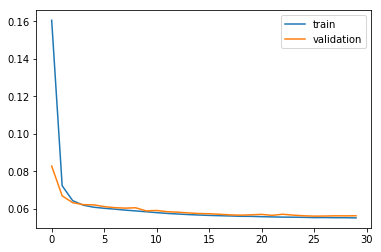

In [11]:
# Fit the network
history = model.fit(x_training, y_training, epochs=30, batch_size=72, validation_data=(x_validation, y_validation), verbose=1, shuffle=False)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()


One can see in the graph above, that the validation loss hits a floor around the 25th epoch - and while the training loss does decrease (albeit at a slow rate) the validation loss does not - indicating slight but small overfitting.

<p style="text-align: left;"><span style="text-decoration: underline;"><strong>MODEL EVALUATION</strong></span></p>
<p>Below I use this model to create a prediction - and after the prediction is de-scaled back to the original temperature values, my predicted temperatures are added to the template and saved to disk.</p>

In [12]:
# Make a prediction with my model
pred = model.predict(x_testing)

# De-scale the predicted values into normal Celcius values
inv_pred = pred*8.01432 + 10.25075    #These values were provided by the Professor, but may not be 100% accurate

In [13]:
# Import the submission template and save it to disk
submission = pd.read_csv("sample_submission_2019spring.txt")
submission.temperature = inv_pred
submission.to_csv('model1d.csv', index=False)
submission.head()

,date time,temperature
0,02.01.2015 00:00:00,1.462562
1,02.01.2015 01:00:00,1.772528
2,02.01.2015 02:00:00,1.692197
3,02.01.2015 03:00:00,1.889138
4,02.01.2015 04:00:00,2.494550
